In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.extraClassPath","/home/neo/Programs/Spark/mysql-connector-java-8.0.23.jar").master("local").appName('operations').getOrCreate()
sc=spark.sparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

21/08/23 16:33:33 WARN Utils: Your hostname, neo resolves to a loopback address: 127.0.1.1, but we couldn't find any external IP address!
21/08/23 16:33:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/23 16:33:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/23 16:33:38 WARN MacAddressUtil: Failed to find a usable hardware address from the network interfaces; using random bytes: ef:a5:23:31:69:36:62:52


In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [5]:
file_data_df = spark.read.format("csv").option("header", "true").load("hdfs://localhost:9000/spark_data/*.csv")

In [5]:
file_data_df.count()

4122

In [6]:
user_data = file_data_df.groupBy("user_name").count()

In [7]:
user_data.repartition(1).write.save('hdfs://localhost:9000/spark_data/record_counts',format='csv',mode='append')

In [8]:
schema = StructType([\
    StructField("user_name", StringType(), True),\
    StructField("count", IntegerType(), True)])

In [9]:
count_df = spark.read.format("csv").option("header", "false").schema(schema).load("hdfs://localhost:9000/spark_data/record_counts/part-00000-fe8be7ac-ddf8-4391-b673-f4b69bca54eb-c000.csv")

In [10]:
count_df.write.format("jdbc").option("url", "jdbc:mysql://localhost:3306/spark_db") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "user_counts") \
    .option("user", "root").option("password", "neo").mode('append').save()

In [31]:
dataframe_mysql = spark.read\
    .format("jdbc")\
    .option("url", "jdbc:mysql://localhost/spark_db")\
    .option("driver", "com.mysql.jdbc.Driver")\
    .option("dbtable", "user_counts").option("user", "root")\
    .option("password", "neo").load()
dataframe_mysql.show()


+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
+--------------------+-----+



Display users and their record counts

In [12]:
count_df.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
+--------------------+-----+



In [59]:
user_data.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
+--------------------+-----+



<AxesSubplot:ylabel='count'>

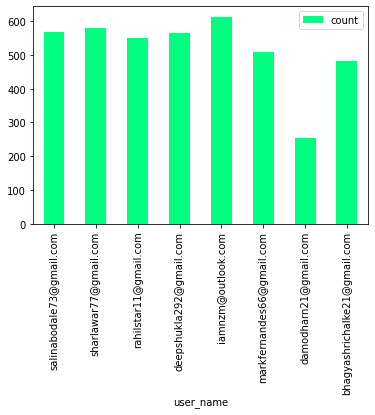

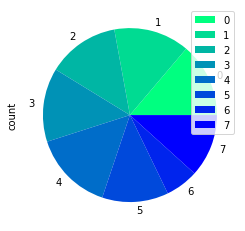

In [86]:
user_data_plot = user_data.toPandas()
user_data_plot.plot(kind='bar',x='user_name',y='count',colormap='winter_r')
user_data_plot.plot(kind='pie',x='user_name',y='count',colormap='winter_r')

Finding users with highest number of average hours

In [12]:
user_data7 = file_data_df.select("user_name").where((file_data_df.keyboard != 0.0) | (file_data_df.mouse != 0.0))


In [13]:
user_data8 = user_data7.groupBy("user_name").count()
user_data8.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  440|
|sharlawar77@gmail...|  457|
|rahilstar11@gmail...|  399|
|deepshukla292@gma...|  475|
|  iamnzm@outlook.com|  459|
|markfernandes66@g...|  389|
|damodharn21@gmail...|  191|
|bhagyashrichalke2...|  361|
+--------------------+-----+



In [14]:
work_seconds = user_data8.withColumn('work_seconds',  ( ( (user_data8['count'] - 1) * 5) * 60)/ 6)

In [33]:
highest_avg_hour = work_seconds.withColumn("average_hours", concat(
            floor(col("work_seconds") % 86400 / 3600), lit(":"),
            floor((col("work_seconds") % 86400) % 3600 / 60), lit(""),
           
        ))\
    .drop("work_seconds")

In [35]:
highest_avg_hour.createOrReplaceTempView("sql_view")
highest_avg_hour1 = spark.sql("SELECT user_name, average_hours FROM sql_view ORDER BY average_hours desc")
highest_avg_hour.show()

+--------------------+-----+-------------+
|           user_name|count|average_hours|
+--------------------+-----+-------------+
|salinabodale73@gm...|  440|          6:5|
|sharlawar77@gmail...|  457|         6:20|
|rahilstar11@gmail...|  399|         5:31|
|deepshukla292@gma...|  475|         6:35|
|  iamnzm@outlook.com|  459|         6:21|
|markfernandes66@g...|  389|         5:23|
|damodharn21@gmail...|  191|         2:38|
|bhagyashrichalke2...|  361|          5:0|
+--------------------+-----+-------------+



In [39]:
highest_avg_hour1.repartition(1).write.save('hdfs://localhost:9000/spark_data/highest_avg_hours',format='csv',mode='append')
schema = StructType([\
    StructField("user_name", StringType(), True),\
    StructField("highest_avg_hours", StringType(), True)])


In [40]:
count_df = spark.read.format("csv").option("header", "false").schema(schema).load("hdfs://localhost:9000/spark_data/highest_avg_hours/part-00000-f63559ff-d054-42df-bb87-0629406bf6f0-c000.csv")
count_df.write.format("jdbc").option("url", "jdbc:mysql://localhost:3306/spark_db") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "highest_avg_hours") \
    .option("user", "root").option("password", "neo").mode('overwrite').save()

In [41]:
dataframe_mysql = spark.read\
    .format("jdbc")\
    .option("url", "jdbc:mysql://localhost/spark_db")\
    .option("driver", "com.mysql.jdbc.Driver")\
    .option("dbtable", "highest_avg_hours").option("user", "root")\
    .option("password", "neo").load()
dataframe_mysql.show()


+--------------------+-----------------+
|           user_name|highest_avg_hours|
+--------------------+-----------------+
|salinabodale73@gm...|              6:5|
|deepshukla292@gma...|             6:35|
|  iamnzm@outlook.com|             6:21|
|sharlawar77@gmail...|             6:20|
|rahilstar11@gmail...|             5:31|
|markfernandes66@g...|             5:23|
|bhagyashrichalke2...|              5:0|
|damodharn21@gmail...|             2:38|
+--------------------+-----------------+



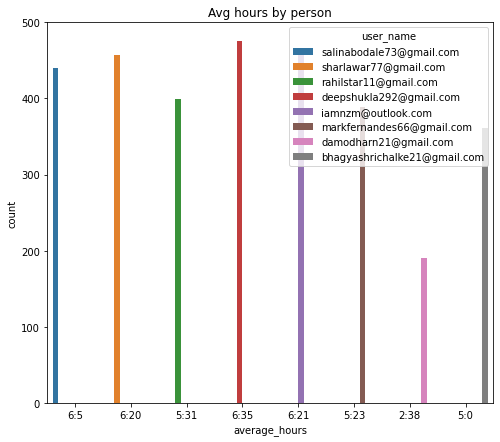

In [21]:
df = highest_avg_hour.toPandas()
plt.figure(figsize = (8,7))
sns.barplot(x = 'average_hours',y='count',data = df,hue='user_name')
plt.title("Avg hours by person")
plt.ylim(0,500)
plt.show()

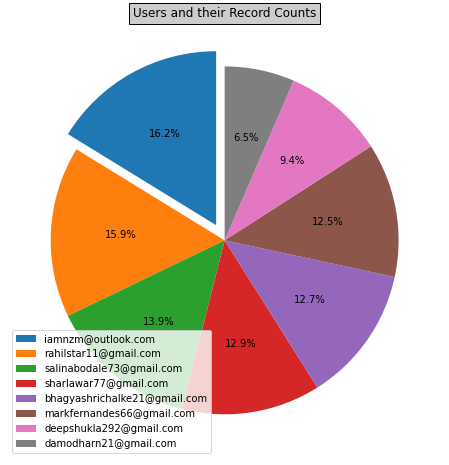

In [116]:
 
user_data = df["user_name"]
count_data = df["count"]

fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('w')
explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
# Plot
plt.pie(count_data,autopct='%1.1f%%',startangle=90,explode=explode,)
plt.title('Users and their Record Counts',bbox={'facecolor':'0.8', 'pad':4})
plt.legend(user_data,loc="lower left")


Finding users with lowest number of average hours

In [22]:
highest_avg_hour.createOrReplaceTempView("sql_view1")
lowest_avg_hour = spark.sql("SELECT user_name, count, average_hours FROM sql_view1 ORDER BY average_hours asc")
lowest_avg_hour.show()

+--------------------+-----+-------------+
|           user_name|count|average_hours|
+--------------------+-----+-------------+
|damodharn21@gmail...|  191|         2:38|
|bhagyashrichalke2...|  361|          5:0|
|markfernandes66@g...|  389|         5:23|
|rahilstar11@gmail...|  399|         5:31|
|sharlawar77@gmail...|  457|         6:20|
|  iamnzm@outlook.com|  459|         6:21|
|deepshukla292@gma...|  475|         6:35|
|salinabodale73@gm...|  440|          6:5|
+--------------------+-----+-------------+



In [23]:
lowest_avg_hour.repartition(1).write.save('hdfs://localhost:9000/spark_data/lowest_avg_hours',format='csv',mode='append')
schema = StructType([\
    StructField("user_name", StringType(), True),\
    StructField("count", IntegerType(), True),\
    StructField("lowest_avg_hours", StringType(), True)])



In [24]:
count_df = spark.read.format("csv").option("header", "false").schema(schema).load("hdfs://localhost:9000/spark_data/lowest_avg_hours/part-00000-4a82118a-4c81-4c02-9cf4-7ef1dae23678-c000.csv")
count_df.write.format("jdbc").option("url", "jdbc:mysql://localhost:3306/spark_db") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "lowest_avg_hours") \
    .option("user", "root").option("password", "neo").mode('append').save()

In [42]:
dataframe_mysql = spark.read\
    .format("jdbc")\
    .option("url", "jdbc:mysql://localhost/spark_db")\
    .option("driver", "com.mysql.jdbc.Driver")\
    .option("dbtable", "lowest_avg_hours").option("user", "root")\
    .option("password", "neo").load()
dataframe_mysql.show()

+--------------------+-----+----------------+
|           user_name|count|lowest_avg_hours|
+--------------------+-----+----------------+
|damodharn21@gmail...|  191|            2:38|
|bhagyashrichalke2...|  361|             5:0|
|markfernandes66@g...|  389|            5:23|
|rahilstar11@gmail...|  399|            5:31|
|sharlawar77@gmail...|  457|            6:20|
|  iamnzm@outlook.com|  459|            6:21|
|deepshukla292@gma...|  475|            6:35|
|salinabodale73@gm...|  440|             6:5|
+--------------------+-----+----------------+



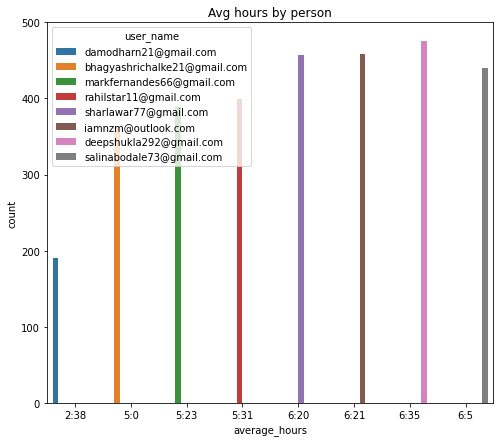

In [118]:
df = lowest_avg_hour.toPandas()
plt.figure(figsize = (8,7))
sns.barplot(x = 'average_hours',y='count',data = df,hue='user_name')
plt.title("Avg hours by person")
plt.ylim(0,500)
plt.show()

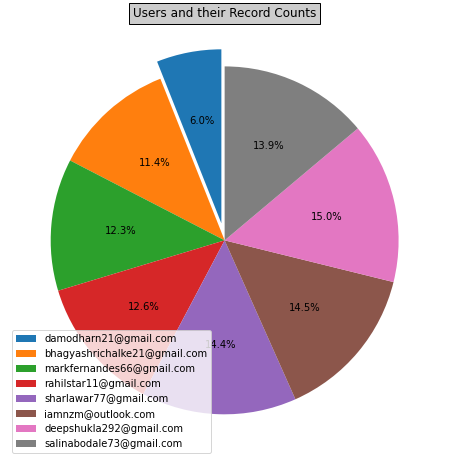

In [119]:
user_data = df["user_name"]
count_data = df["count"]

fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('w')
explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
# Plot
plt.pie(count_data,autopct='%1.1f%%',startangle=90,explode=explode,)
plt.title('Users and their Record Counts',bbox={'facecolor':'0.8', 'pad':4})
plt.legend(user_data,loc="lower left")


Finding users with highest numbers of idle hours

In [25]:
columns1 = ['user_name', 'keyboard', 'mouse']
user_data5 = file_data_df.select("user_name","keyboard","mouse").where((file_data_df.keyboard==0)&(file_data_df.mouse==0)).toDF(*columns1)

In [26]:
user_data6 = user_data5.groupBy("user_name").count()

In [27]:
idle_minit = user_data6.withColumn('idle_minits',  ( ((user_data6['count'] - 1) * 5) * 60 / 6) )  
idle_minit.show(truncate=False)

+----------------------------+-----+-----------+
|user_name                   |count|idle_minits|
+----------------------------+-----+-----------+
|salinabodale73@gmail.com    |133  |6600.0     |
|sharlawar77@gmail.com       |123  |6100.0     |
|rahilstar11@gmail.com       |152  |7550.0     |
|deepshukla292@gmail.com     |90   |4450.0     |
|iamnzm@outlook.com          |155  |7700.0     |
|markfernandes66@gmail.com   |119  |5900.0     |
|damodharn21@gmail.com       |62   |3050.0     |
|bhagyashrichalke21@gmail.com|121  |6000.0     |
+----------------------------+-----+-----------+



In [28]:
idle_hour = idle_minit.withColumn("idle_hours", concat(
            floor(col("idle_minits") % 86400 / 3600), lit(":"),
            floor((col("idle_minits") % 86400) % 3600 / 60), lit(""),
           
        ))\
    .drop("idle_minits")\
    .sort(desc("idle_hours"))


In [114]:
idle_hour.show(truncate=False)

+----------------------------+-----+----------+
|user_name                   |count|idle_hours|
+----------------------------+-----+----------+
|iamnzm@outlook.com          |155  |2:8       |
|rahilstar11@gmail.com       |152  |2:5       |
|salinabodale73@gmail.com    |133  |1:50      |
|sharlawar77@gmail.com       |123  |1:41      |
|bhagyashrichalke21@gmail.com|121  |1:40      |
|markfernandes66@gmail.com   |119  |1:38      |
|deepshukla292@gmail.com     |90   |1:14      |
|damodharn21@gmail.com       |62   |0:50      |
+----------------------------+-----+----------+



In [29]:
idle_hour.repartition(1).write.save('hdfs://localhost:9000/spark_data/idle_hour',format='csv',mode='append')
schema = StructType([\
    StructField("user_name", StringType(), True),\
    StructField("count", IntegerType(), True),\
    StructField("idle_hour", StringType(), True)])


In [30]:
count_df = spark.read.format("csv").option("header", "false").schema(schema).load("hdfs://localhost:9000/spark_data/idle_hour/part-00000-4c619320-8c49-4387-b98b-c0983663dd32-c000.csv")
count_df.write.format("jdbc").option("url", "jdbc:mysql://localhost:3306/spark_db") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "idle_hour") \
    .option("user", "root").option("password", "neo").mode('append').save()

In [43]:
dataframe_mysql = spark.read\
    .format("jdbc")\
    .option("url", "jdbc:mysql://localhost/spark_db")\
    .option("driver", "com.mysql.jdbc.Driver")\
    .option("dbtable", "idle_hour").option("user", "root")\
    .option("password", "neo").load()
dataframe_mysql.show()

+--------------------+-----+---------+
|           user_name|count|idle_hour|
+--------------------+-----+---------+
|  iamnzm@outlook.com|  155|      2:8|
|rahilstar11@gmail...|  152|      2:5|
|salinabodale73@gm...|  133|     1:50|
|sharlawar77@gmail...|  123|     1:41|
|bhagyashrichalke2...|  121|     1:40|
|markfernandes66@g...|  119|     1:38|
|deepshukla292@gma...|   90|     1:14|
|damodharn21@gmail...|   62|     0:50|
+--------------------+-----+---------+



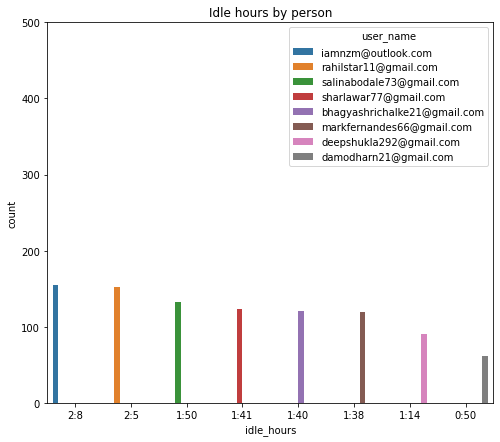

In [120]:
df = idle_hour.toPandas()
plt.figure(figsize = (8,7))
sns.barplot(x = 'idle_hours',y='count',data = df,hue='user_name')
plt.title("Idle hours by person")
plt.ylim(0,500)
plt.show()

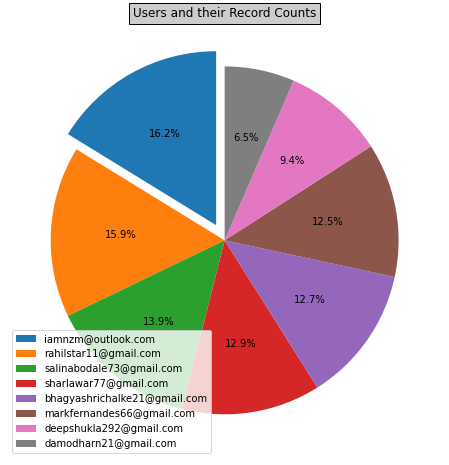

In [121]:
user_data = df["user_name"]
count_data = df["count"]

fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('w')
explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
# Plot
plt.pie(count_data,autopct='%1.1f%%',startangle=90,explode=explode,)
plt.title('Users and their Record Counts',bbox={'facecolor':'0.8', 'pad':4})
plt.legend(user_data,loc="lower left")
